In [14]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('/content/drive/MyDrive/Dissertation')

###Setup Imports 

In [15]:
!pip install optuna lightgbm xgboost==1.7.5 -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import optuna
from optuna.samplers import TPESampler
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import joblib

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

####Helper Functions

In [16]:
# -------------------------------
# Step 2: Helper Functions
# -------------------------------
def load_and_preprocess_data(data):
    """Preprocess data consistently across models."""
    # Normalize column names: trim and lower-case
    data.columns = data.columns.str.strip()
    data.columns = data.columns.str.lower()
    # Create mapping from known CSV column names to standard names
    mapping = {
        'start date/time': 'StartDateTime',
        'temperature': 'temperature',
        'relative humidity': 'relative_humidity',
        'precipitation': 'precipitation',
        'rain': 'rain',
        'snowfall': 'snowfall',
        'weather code': 'weather_code',
        'wind speed': 'wind_speed',
        'price': 'Price',
        'grid load': 'total_consumption',
        'total generation': 'total_generation',
        'day of week': 'DayOfWeek'
    }
    # Rename columns if present
    new_cols = {}
    for col in data.columns:
        if col in mapping:
            new_cols[col] = mapping[col]
    data.rename(columns=new_cols, inplace=True)

    # Define potential numeric columns
    potential_numeric_cols = [
        'Price', 'total_consumption', 'temperature', 'precipitation', 'rain',
        'snowfall', 'wind_speed', 'relative_humidity', 'weather_code', 'total_generation'
    ]
    # Select only columns that exist in the dataframe
    numeric_cols = [col for col in potential_numeric_cols if col in data.columns]

    # Convert numeric columns (handle commas as thousand separators)
    for col in numeric_cols:
        data[col] = pd.to_numeric(
            data[col].astype(str)
            .str.replace(',', '')  # Remove commas
            .str.replace(' ', '')
            .str.replace('–', '-'),
            errors='coerce'
        )

    # Parse datetime – assuming format dd/mm/yyyy HH:MM
    data['StartDateTime'] = pd.to_datetime(data['StartDateTime'], format='%d/%m/%Y %H:%M', errors='coerce')
    data = data.sort_values('StartDateTime').dropna(subset=['StartDateTime']).reset_index(drop=True)

    # Map DayOfWeek to numeric (Monday=0, …, Sunday=6)
    day_map = {'monday': 0, 'tuesday': 1, 'wednesday': 2, 'thursday': 3,
               'friday': 4, 'saturday': 5, 'sunday': 6}
    if 'dayofweek' in data.columns:
        data['DayOfWeek'] = data['DayOfWeek'].str.strip().str.lower().map(day_map)
        data = data.dropna(subset=['DayOfWeek'])

    # Interpolate numeric columns and fill missing values
    for col in data.columns:
        if data[col].dtype in [np.float64, np.int64]:
            data[col] = data[col].interpolate(method='linear', limit_direction='both')
            data[col] = data[col].ffill().bfill()

    # Debugging: Check for NaN values in existing numeric columns
    print("NaN counts after preprocessing:", data[numeric_cols].isna().sum())
    return data

def evaluate_model(y_true, y_pred, model_name, return_metrics=False):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, a_min=0.01, a_max=None))) * 100
    smape = 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))
    print(f"=== {model_name} Evaluation ===")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"SMAPE: {smape:.2f}%")
    if return_metrics:
        return rmse, mae, r2, mape, smape

def plot_predictions(dates, y_true, y_pred, title):
    """Plot actual vs. predicted values."""
    plt.figure(figsize=(14, 7))
    plt.plot(dates, y_true, label='Actual', color='red', marker='x')
    plt.plot(dates, y_pred, label='Predicted', color='blue', marker='o')
    plt.xlabel('Date and Time')
    plt.ylabel('Price [Euro/MWh]')
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def engineer_features(data):
    """Engineer features consistently across models."""
    df = data.copy()
    df['Hour'] = df['StartDateTime'].dt.hour
    df['Day'] = df['StartDateTime'].dt.day
    df['DayOfWeek'] = pd.to_numeric(df['DayOfWeek'], errors='coerce')
    df['Hour'] = pd.to_numeric(df['Hour'], errors='coerce')
    # Create cyclic features for hour and day-of-week
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    # Lag features for Price (if exists)
    if 'Price' in df.columns:
        df['Lag_Price_1h'] = df['Price'].shift(1)
        df['Lag_Price_24h'] = df['Price'].shift(24)
        df['Price_RollingStd24'] = df['Price'].rolling(window=24, min_periods=1).std()
        # Fill NaN values in lag and rolling features
        df['Lag_Price_1h'] = df['Lag_Price_1h'].interpolate(method='linear', limit_direction='both').ffill().bfill()
        df['Lag_Price_24h'] = df['Lag_Price_24h'].interpolate(method='linear', limit_direction='both').ffill().bfill()
        df['Price_RollingStd24'] = df['Price_RollingStd24'].interpolate(method='linear', limit_direction='both').ffill().bfill()
    else:
        df['Lag_Price_1h'] = np.nan
        df['Lag_Price_24h'] = np.nan
        df['Price_RollingStd24'] = np.nan
    # Rolling features for temperature, wind speed, and total_consumption
    df['Rolling_Temp_24h'] = df['temperature'].rolling(window=24, min_periods=1).mean()
    df['Rolling_Wind_24h'] = df['wind_speed'].rolling(window=24, min_periods=1).mean()
    df['Rolling_Load_24h'] = df['total_consumption'].rolling(window=24, min_periods=1).mean()
    return df

####Load and Preprocess Data

In [17]:
# -------------------------------
# Step 3: Load and Preprocess Data
# -------------------------------
historical_data = pd.read_csv('data/merged-data.csv')
future_data = pd.read_csv('data/future-data.csv')
historical_data = load_and_preprocess_data(historical_data)
future_data = load_and_preprocess_data(future_data)

# Historical data is assumed to span Feb 09 2022 to Feb 09 2025.
# For future forecasting, filter dates Feb 10 2025 to Feb 16 2025.
forecast_start_dt = pd.to_datetime('2025-02-10 00:00:00')
forecast_end_dt = pd.to_datetime('2025-02-16 23:00:00')
future_data = future_data[
    (future_data['StartDateTime'] >= forecast_start_dt) &
    (future_data['StartDateTime'] <= forecast_end_dt)
].reset_index(drop=True)

# Engineer features on both datasets
historical_data = engineer_features(historical_data)
future_data = engineer_features(future_data)

dates = historical_data['StartDateTime'].copy()
print("Dates saved. First few entries:\n", dates.head())

NaN counts after preprocessing: Price                0
total_consumption    0
temperature          0
precipitation        0
rain                 0
snowfall             0
wind_speed           0
relative_humidity    0
weather_code         0
total_generation     0
dtype: int64
NaN counts after preprocessing: total_consumption    0
temperature          0
precipitation        0
rain                 0
snowfall             0
wind_speed           0
relative_humidity    0
weather_code         0
total_generation     0
dtype: int64
Dates saved. First few entries:
 0   2022-02-09 00:00:00
1   2022-02-09 01:00:00
2   2022-02-09 02:00:00
3   2022-02-09 03:00:00
4   2022-02-09 04:00:00
Name: StartDateTime, dtype: datetime64[ns]


###Feature Selection & Correlation Analysis

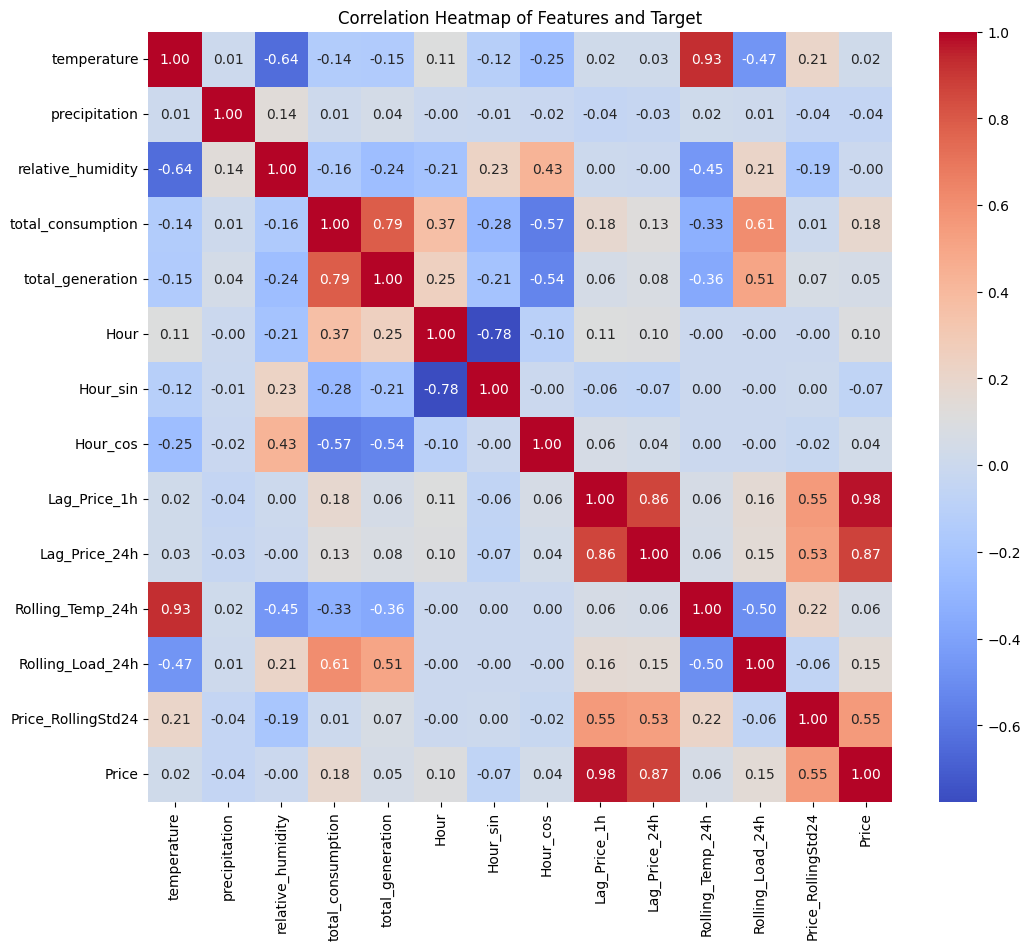

Features with absolute correlation > 0.1 with target: ['total_consumption', 'Hour', 'Lag_Price_1h', 'Lag_Price_24h', 'Rolling_Load_24h', 'Price_RollingStd24']
Selected features after dropping highly correlated ones: ['total_consumption', 'Hour', 'Lag_Price_1h', 'Lag_Price_24h', 'Rolling_Load_24h', 'Price_RollingStd24']
Dropped features due to high inter-correlation: []
Final feature set for modeling: ['temperature', 'precipitation', 'relative_humidity', 'total_consumption', 'total_generation', 'Hour', 'Hour_sin', 'Hour_cos', 'Lag_Price_1h', 'Lag_Price_24h', 'Rolling_Temp_24h', 'Rolling_Load_24h', 'Price_RollingStd24']


In [18]:
# -------------------------------
# Step 5: Feature Selection & Correlation Analysis
# -------------------------------
# Candidate features (engineered) and target Price
target = 'Price'
common_features = [
    'temperature', 'precipitation',
  'relative_humidity', 'total_consumption', 'total_generation', 'Hour',
    'Hour_sin', 'Hour_cos',
    'Lag_Price_1h', 'Lag_Price_24h', 'Rolling_Temp_24h',
    'Rolling_Load_24h', 'Price_RollingStd24'
]


# common_features = [
#     'temperature', 'precipitation', 'rain', 'snowfall',
#     'wind_speed', 'relative_humidity', 'total_consumption',
#     'Hour_sin', 'Hour_cos',
#     'Lag_Price_1h', 'Lag_Price_24h', 'Rolling_Temp_24h',
#     'Rolling_Load_24h', 'Price_RollingStd24'
# ]

# Check for problematic columns
for col in common_features + [target]:
    if col not in historical_data.columns:
        print(f"Warning: Column {col} not in historical_data.")
    elif historical_data[col].isna().all():
        print(f"Warning: Column {col} is entirely NaN.")
    elif historical_data[col].nunique() == 1:
        print(f"Warning: Column {col} is constant with value {historical_data[col].iloc[0]}.")

corr_matrix = historical_data[common_features + [target]].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Features and Target")
plt.show()

# Feature selection
target_corr = corr_matrix[target].drop(target)
selected_features = target_corr[target_corr.abs() > 0.1].index.tolist()
print("Features with absolute correlation > 0.1 with target:", selected_features)

def drop_highly_correlated_features(df, features, threshold=0.9):
    corr = df[features].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return [feature for feature in features if feature not in to_drop], to_drop

selected_features, dropped_features = drop_highly_correlated_features(historical_data, selected_features, threshold=0.9)
print("Selected features after dropping highly correlated ones:", selected_features)
print("Dropped features due to high inter-correlation:", dropped_features)

#common_features = selected_features
print("Final feature set for modeling:", common_features)

####Split Historical Data

In [19]:
# -------------------------------
# Step 6: Split Historical Data Evenly (Train, Validation, Test)
# -------------------------------
features_and_target = common_features + [target]
historical_data = historical_data[features_and_target].dropna().reset_index(drop=True)

# Calculate the split sizes: 60% train, 20% validation, 20% test
n = len(historical_data)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

# Split the data while preserving temporal order
train_data = historical_data.iloc[:train_end].reset_index(drop=True)
val_data = historical_data.iloc[train_end:val_end].reset_index(drop=True)
test_data = historical_data.iloc[val_end:].reset_index(drop=True)

# Print the sizes of each split to verify
print(f"Train: {len(train_data)} rows, Validation: {len(val_data)} rows, Test: {len(test_data)} rows")

# Verify no missing values remain in the splits
print("Missing values in train_data:", train_data.isna().sum().sum())
print("Missing values in val_data:", val_data.isna().sum().sum())
print("Missing values in test_data:", test_data.isna().sum().sum())

Train: 15796 rows, Validation: 5266 rows, Test: 5266 rows
Missing values in train_data: 0
Missing values in val_data: 0
Missing values in test_data: 0


####XGBoost

[I 2025-04-04 14:56:47,104] A new study created in memory with name: no-name-9ea961e2-9d72-4290-8f16-305749aaef4a


[I 2025-04-04 14:56:49,378] Trial 0 finished with value: 855.9630363577887 and parameters: {'n_estimators': 106, 'max_depth': 6, 'learning_rate': 0.07587945476302646, 'subsample': 0.8197316968394073, 'colsample_bytree': 0.7312037280884873, 'gamma': 0.2403950683025824, 'min_child_weight': 3, 'reg_alpha': 8.795585311974417, 'reg_lambda': 6.41003510568888}. Best is trial 0 with value: 855.9630363577887.
[I 2025-04-04 14:56:51,398] Trial 1 finished with value: 528.9460659995059 and parameters: {'n_estimators': 156, 'max_depth': 3, 'learning_rate': 0.0972918866945795, 'subsample': 0.8664885281600844, 'colsample_bytree': 0.7424678221356552, 'gamma': 0.26364247048639056, 'min_child_weight': 4, 'reg_alpha': 3.7381801866358395, 'reg_lambda': 5.72280788469014}. Best is trial 1 with value: 528.9460659995059.
[I 2025-04-04 14:56:54,017] Trial 2 finished with value: 637.9018167247835 and parameters: {'n_estimators': 115, 'max_depth': 4, 'learning_rate': 0.06506676052501416, 'subsample': 0.727898772

Best parameters for XGBoost: {'n_estimators': 186, 'max_depth': 3, 'learning_rate': 0.04204821010014945, 'subsample': 0.8843778513962932, 'colsample_bytree': 0.87810800597381, 'gamma': 0.31904112037078824, 'min_child_weight': 8, 'reg_alpha': 6.4646584662990305, 'reg_lambda': 1.0812147167496493}
=== XGBoost (Test) Evaluation ===
RMSE: 21.22
MAE: 11.01
R²: 0.8857
MAPE: 3222.75%
SMAPE: 21.98%


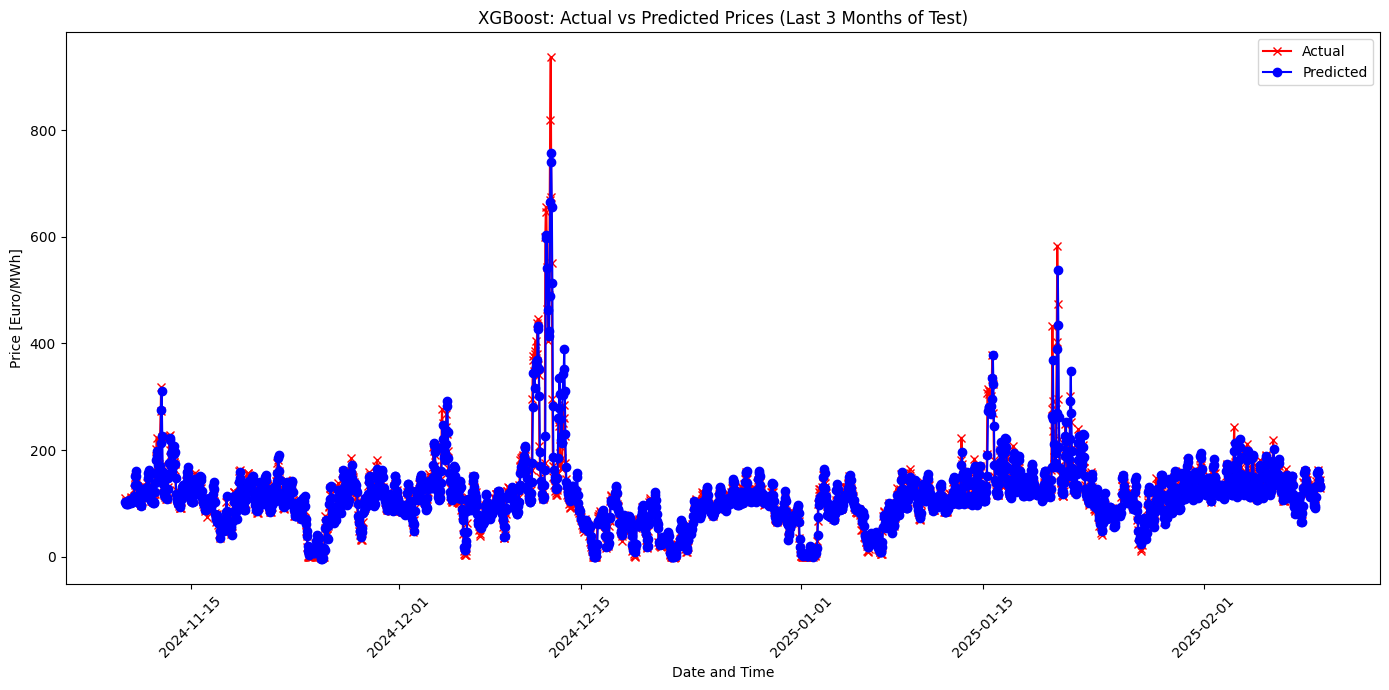

XGBoost model and scaler saved successfully.


In [20]:
# -------------------------------
# Step 7: XGBoost Model Training & Hyperparameter Tuning
# -------------------------------
# For modeling, skip the first 24 rows (to avoid NaNs from lag features)
train_val = pd.concat([train_data, val_data]).iloc[24:].reset_index(drop=True)
X = train_val[common_features].copy()
y = train_val[target].copy()
X = X.ffill().bfill().fillna(0)

# Scale features
scaler_xgb = RobustScaler()
X_scaled = scaler_xgb.fit_transform(X)

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'gamma': trial.suggest_float('gamma', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10),
        'random_state': 42,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
    }
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    for train_idx, val_idx in tscv.split(X_scaled):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        y_pred = model.predict(X_val)
        scores.append(mean_squared_error(y_val, y_pred))
    return np.mean(scores)

study_xgb = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study_xgb.optimize(objective_xgb, n_trials=20)
best_params_xgb = study_xgb.best_params
print("Best parameters for XGBoost:", best_params_xgb)

# Train final model on train+validation
model_xgb = xgb.XGBRegressor(**best_params_xgb, random_state=42)
model_xgb.fit(X_scaled, y)

# Evaluate on test set
X_test = test_data[common_features].copy().ffill().bfill().fillna(0)
y_test = test_data[target]
X_test_scaled = scaler_xgb.transform(X_test)
y_pred_xgb = model_xgb.predict(X_test_scaled)
evaluate_model(y_test, y_pred_xgb, "XGBoost (Test)")

# Define test_dates_xgb (dates corresponding to the test set)
test_dates_xgb = dates.iloc[val_end:].reset_index(drop=True)

# Plot actual vs predicted prices for XGBoost (last 3 months)
last_date_xgb = test_dates_xgb.max()
three_months_prior_xgb = last_date_xgb - pd.DateOffset(months=3)
start_idx_xgb = test_dates_xgb.searchsorted(three_months_prior_xgb, side='left')
test_dates_last_3m_xgb = test_dates_xgb.iloc[start_idx_xgb:]
y_test_last_3m_xgb = y_test.iloc[start_idx_xgb:]
y_pred_last_3m_xgb = y_pred_xgb[start_idx_xgb:]
plot_predictions(test_dates_last_3m_xgb, y_test_last_3m_xgb, y_pred_last_3m_xgb, "XGBoost: Actual vs Predicted Prices (Last 3 Months of Test)")

joblib.dump(model_xgb, 'xgb_model.pkl')
joblib.dump(scaler_xgb, 'scaler_xgb.pkl')
print("XGBoost model and scaler saved successfully.")

####LSTM

In [25]:
X_lstm = historical_data[common_features].iloc[24:].copy()
y_lstm = historical_data.loc[X_lstm.index, target].copy()
X_lstm = X_lstm.ffill().bfill().fillna(0)  # Handle missing values

# Scale features and target with StandardScaler
scaler_X_lstm = StandardScaler()
X_lstm_scaled = scaler_X_lstm.fit_transform(X_lstm)

scaler_y_lstm = StandardScaler()
y_lstm_scaled = scaler_y_lstm.fit_transform(y_lstm.values.reshape(-1, 1)).flatten()

# Create sequences with reduced time steps
time_steps = 24  # Reduced from 36
def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_lstm_scaled, y_lstm_scaled, time_steps)
mask = ~np.isnan(X_seq).any(axis=(1, 2)) & ~np.isnan(y_seq)
X_seq = X_seq[mask]
y_seq = y_seq[mask]

# Optuna objective function for hyperparameter tuning
def objective_lstm(trial):
    lstm_units_1 = trial.suggest_int('lstm_units_1', 16, 64)
    lstm_units_2 = trial.suggest_int('lstm_units_2', 8, 32)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    # Build model
    inputs = Input(shape=(time_steps, len(common_features)))
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True, kernel_regularizer=l2(0.01)))(inputs)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units_2, return_sequences=False, kernel_regularizer=l2(0.01)))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='mean_squared_error')

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6)

    # Train model
    history = model.fit(
        X_seq, y_seq,
        epochs=150,
        batch_size=32,  # Reduced from 64
        validation_split=0.1,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    # Return validation loss
    return min(history.history['val_loss'])

# Run Optuna study
study_lstm = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study_lstm.optimize(objective_lstm, n_trials=20)
best_params_lstm = study_lstm.best_params
print("Best parameters for LSTM:", best_params_lstm)

# Build final LSTM model
def build_final_lstm_model(time_steps, n_features, params):
    inputs = Input(shape=(time_steps, n_features))
    x = Bidirectional(LSTM(params['lstm_units_1'], return_sequences=True, kernel_regularizer=l2(0.01)))(inputs)
    x = Dropout(params['dropout_rate'])(x)
    x = Bidirectional(LSTM(params['lstm_units_2'], return_sequences=False, kernel_regularizer=l2(0.01)))(x)
    x = Dropout(params['dropout_rate'])(x)
    x = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=params['learning_rate'], clipnorm=1.0), loss='mean_squared_error')
    return model

model_lstm = build_final_lstm_model(time_steps, len(common_features), best_params_lstm)

# Train with callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6)

history_lstm = model_lstm.fit(
    X_seq, y_seq,
    epochs=150,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate on test data
train_size = int(len(X_seq) * 0.8)
X_test_lstm = X_seq[train_size:]
y_test_lstm_scaled = y_seq[train_size:]
y_pred_lstm_scaled = model_lstm.predict(X_test_lstm).flatten()
y_pred_lstm = scaler_y_lstm.inverse_transform(y_pred_lstm_scaled.reshape(-1, 1)).flatten()
y_test_lstm = scaler_y_lstm.inverse_transform(y_test_lstm_scaled.reshape(-1, 1)).flatten()
evaluate_model(y_test_lstm, y_pred_lstm, "LSTM (Test)")

# Define test dates
start_test_idx = 24 + time_steps + train_size
end_test_idx = 24 + time_steps + len(X_seq)
test_dates_lstm = dates.iloc[start_test_idx:end_test_idx].reset_index(drop=True)

# Plot test predictions (last 3 months)
last_date_lstm = test_dates_lstm.max()
three_months_prior_lstm = last_date_lstm - pd.DateOffset(months=3)
start_idx_lstm = test_dates_lstm.searchsorted(three_months_prior_lstm, side='left')
test_dates_last_3m_lstm = test_dates_lstm.iloc[start_idx_lstm:]
y_test_last_3m_lstm = y_test_lstm[start_idx_lstm:]
y_pred_last_3m_lstm = y_pred_lstm[start_idx_lstm:]
plot_predictions(test_dates_last_3m_lstm, y_test_last_3m_lstm, y_pred_last_3m_lstm, "LSTM: Actual vs Predicted Prices (Last 3 Months of Test)")

[I 2025-04-04 15:27:43,964] A new study created in memory with name: no-name-6bc1247f-7585-426e-9358-3a9f27131dff
[I 2025-04-04 15:38:35,836] Trial 0 finished with value: 0.09161438047885895 and parameters: {'lstm_units_1': 34, 'lstm_units_2': 31, 'dropout_rate': 0.4195981825434215, 'learning_rate': 0.0015751320499779737}. Best is trial 0 with value: 0.09161438047885895.
[I 2025-04-04 15:50:37,482] Trial 1 finished with value: 0.08799875527620316 and parameters: {'lstm_units_1': 23, 'lstm_units_2': 11, 'dropout_rate': 0.21742508365045984, 'learning_rate': 0.005399484409787433}. Best is trial 1 with value: 0.08799875527620316.
[I 2025-04-04 16:05:32,469] Trial 2 finished with value: 0.09021605551242828 and parameters: {'lstm_units_1': 45, 'lstm_units_2': 25, 'dropout_rate': 0.20617534828874073, 'learning_rate': 0.008706020878304856}. Best is trial 1 with value: 0.08799875527620316.
[I 2025-04-04 16:21:05,867] Trial 3 finished with value: 0.0982501357793808 and parameters: {'lstm_units_1

####Hybrid Model (XGB + LSTM)

In [22]:
# -------------------------------
# Step 8: Hybrid Model (XGBoost + LSTM)
# -------------------------------

# Step A: Generate LSTM predictions on full historical data
X_full = historical_data[common_features].copy()
X_full = X_full.ffill().bfill().fillna(0)
X_full_scaled = scaler_X_lstm.transform(X_full)
X_full_sequences = np.array([
    X_full_scaled[i - time_steps:i]
    for i in range(time_steps, len(X_full_scaled))
])

# Generate predictions and inverse transform to original scale
lstm_preds_scaled = model_lstm.predict(X_full_sequences, verbose=0).flatten()
lstm_preds = scaler_y_lstm.inverse_transform(lstm_preds_scaled.reshape(-1, 1)).flatten()

# Step B: Merge LSTM predictions back into historical data
df_lstm = historical_data.reset_index(drop=False)
df_lstm['global_idx'] = df_lstm.index
df_preds = pd.DataFrame({
    'global_idx': df_lstm.index[time_steps:],
    'LSTM_pred': lstm_preds
})

df_merged = pd.merge(df_lstm, df_preds, on='global_idx', how='left')
df_merged['LSTM_pred'] = df_merged['LSTM_pred'].ffill().fillna(0)
df_merged = df_merged.dropna(subset=[target])

# Step C: Create hybrid features
hybrid_features = common_features + ['LSTM_pred']
y_hybrid_log = np.log1p(df_merged[target].clip(lower=0.01))
X_hybrid_full = df_merged[hybrid_features].copy()

# Step D: Scale hybrid features
scaler_hybrid = RobustScaler()
X_hybrid_full_scaled = scaler_hybrid.fit_transform(X_hybrid_full)

# Step E: Set up TimeSeriesSplit and Optuna tuning
tscv_hybrid = TimeSeriesSplit(n_splits=5)

def objective_hybrid(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 20),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 20),
        'random_state': 42,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
    }
    scores = []
    for train_idx, val_idx in tscv_hybrid.split(X_hybrid_full_scaled):
        X_train, X_val = X_hybrid_full_scaled[train_idx], X_hybrid_full_scaled[val_idx]
        y_train, y_val = y_hybrid_log.iloc[train_idx], y_hybrid_log.iloc[val_idx]
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        y_pred_log = model.predict(X_val)
        scores.append(mean_squared_error(y_val, y_pred_log))
    return np.mean(scores)

# Step F: Run Optuna optimization
study_hybrid = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study_hybrid.optimize(objective_hybrid, n_trials=10)
best_params_hybrid = study_hybrid.best_params
print("Best parameters for Hybrid Model:", best_params_hybrid)

# Step G: Train final hybrid model
model_hybrid = xgb.XGBRegressor(**best_params_hybrid, random_state=42)
model_hybrid.fit(X_hybrid_full_scaled, y_hybrid_log,
                 eval_set=[(X_hybrid_full_scaled, y_hybrid_log)],
                 early_stopping_rounds=30, verbose=False)

# Step H: Evaluate on test set (last split)
train_idx_hyb, test_idx_hyb = list(tscv_hybrid.split(X_hybrid_full_scaled))[-1]
X_train_hyb, X_test_hyb = X_hybrid_full_scaled[train_idx_hyb], X_hybrid_full_scaled[test_idx_hyb]
y_train_hyb_log, y_test_hyb_log = y_hybrid_log.iloc[train_idx_hyb], y_hybrid_log.iloc[test_idx_hyb]

y_pred_hyb_log = model_hybrid.predict(X_test_hyb)
y_test_hyb = np.expm1(y_test_hyb_log)
y_pred_hyb = np.expm1(y_pred_hyb_log)

evaluate_model(y_test_hyb, y_pred_hyb, "Hybrid (XGBoost + LSTM) (Historical)")

[I 2025-04-04 15:09:57,551] A new study created in memory with name: no-name-97634c83-b61c-4dbe-909b-fd133b6583d0
[I 2025-04-04 15:10:06,286] Trial 0 finished with value: 0.09857371732438981 and parameters: {'n_estimators': 250, 'max_depth': 12, 'learning_rate': 0.22227824312530747, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.07799726016810132, 'min_child_weight': 1, 'reg_alpha': 17.323522915498703, 'reg_lambda': 12.022300234864176}. Best is trial 0 with value: 0.09857371732438981.
[I 2025-04-04 15:10:11,809] Trial 1 finished with value: 0.0932815743926246 and parameters: {'n_estimators': 383, 'max_depth': 3, 'learning_rate': 0.29127385712697834, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'gamma': 0.09091248360355031, 'min_child_weight': 2, 'reg_alpha': 6.0848448591907545, 'reg_lambda': 10.495128632644757}. Best is trial 1 with value: 0.0932815743926246.
[I 2025-04-04 15:10:16,754] Trial 2 finished with value: 0.0941

Best parameters for Hybrid Model: {'n_estimators': 243, 'max_depth': 5, 'learning_rate': 0.16738186411589207, 'subsample': 0.5704621124873813, 'colsample_bytree': 0.9010984903770198, 'gamma': 0.03727532183988541, 'min_child_weight': 7, 'reg_alpha': 15.444895385933147, 'reg_lambda': 3.974313630683448}
=== Hybrid (XGBoost + LSTM) (Historical) Evaluation ===
RMSE: 20.43
MAE: 8.84
R²: 0.8985
MAPE: 172.30%
SMAPE: 17.75%


####Future Forecasting

c:\Users\shiha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
c:\Users\shiha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
c:\Users\shiha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
c:\Users\shiha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
c:\Users\shiha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fit


Evaluating XGBoost on period: 2025-02-10 00:00:00 to 2025-02-16 23:00:00


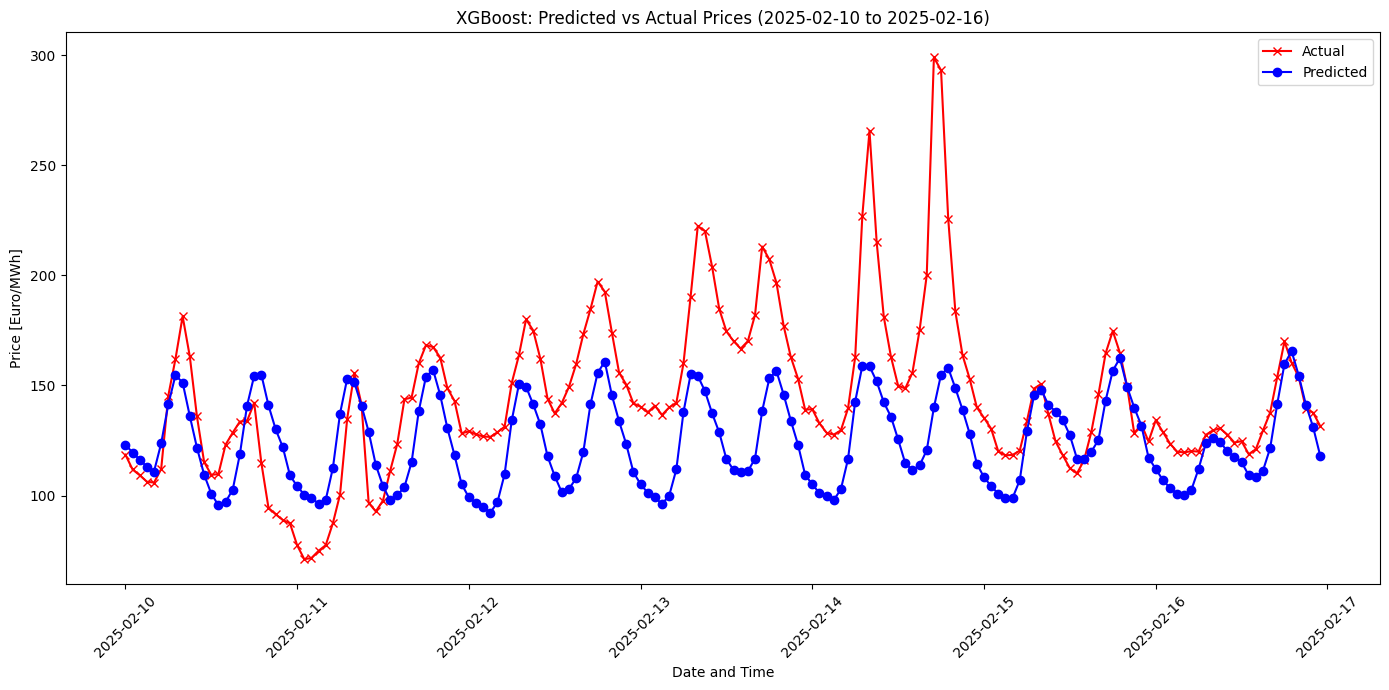

=== XGBoost (Future) Evaluation ===
RMSE: 35.61
MAE: 27.40
R²: 0.0406
MAPE: 18.19%
SMAPE: 19.76%

Evaluating LSTM on period: 2025-02-10 00:00:00 to 2025-02-16 23:00:00


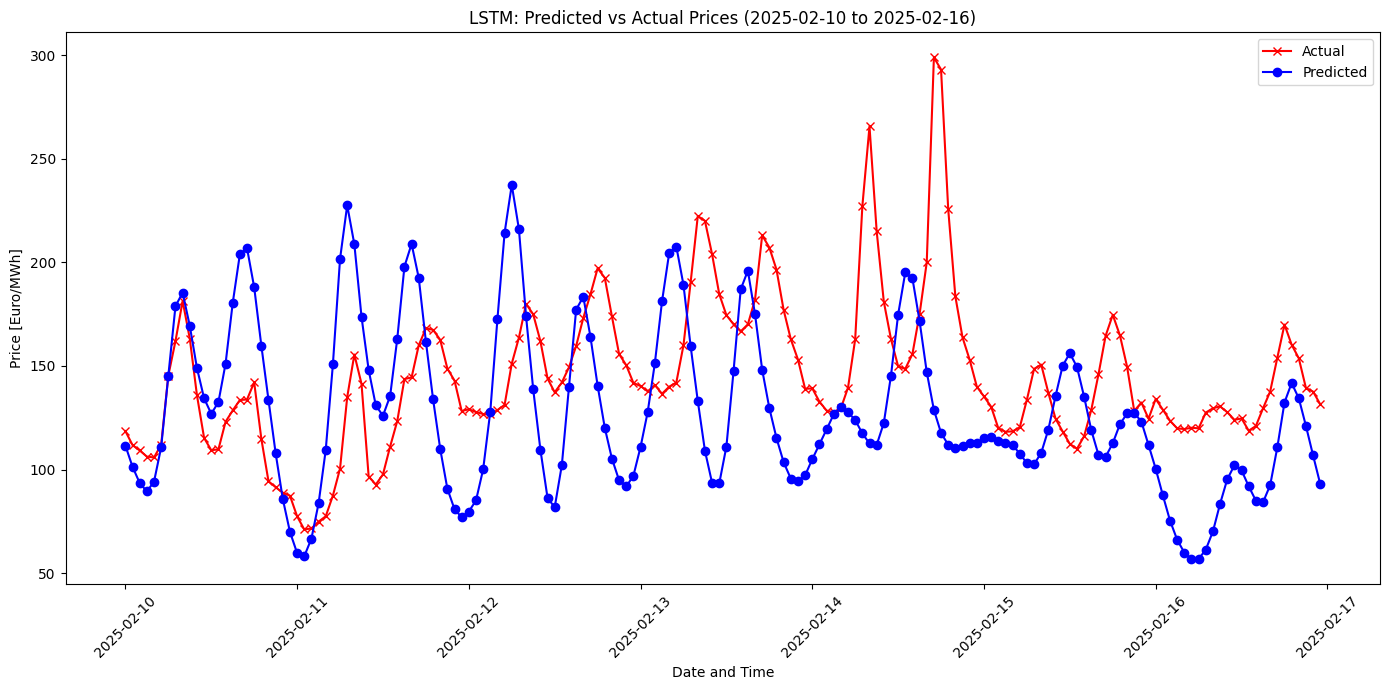

=== LSTM (Future) Evaluation ===
RMSE: 51.26
MAE: 40.88
R²: -0.9872
MAPE: 27.37%
SMAPE: 29.70%

Evaluating Hybrid on period: 2025-02-10 00:00:00 to 2025-02-16 23:00:00


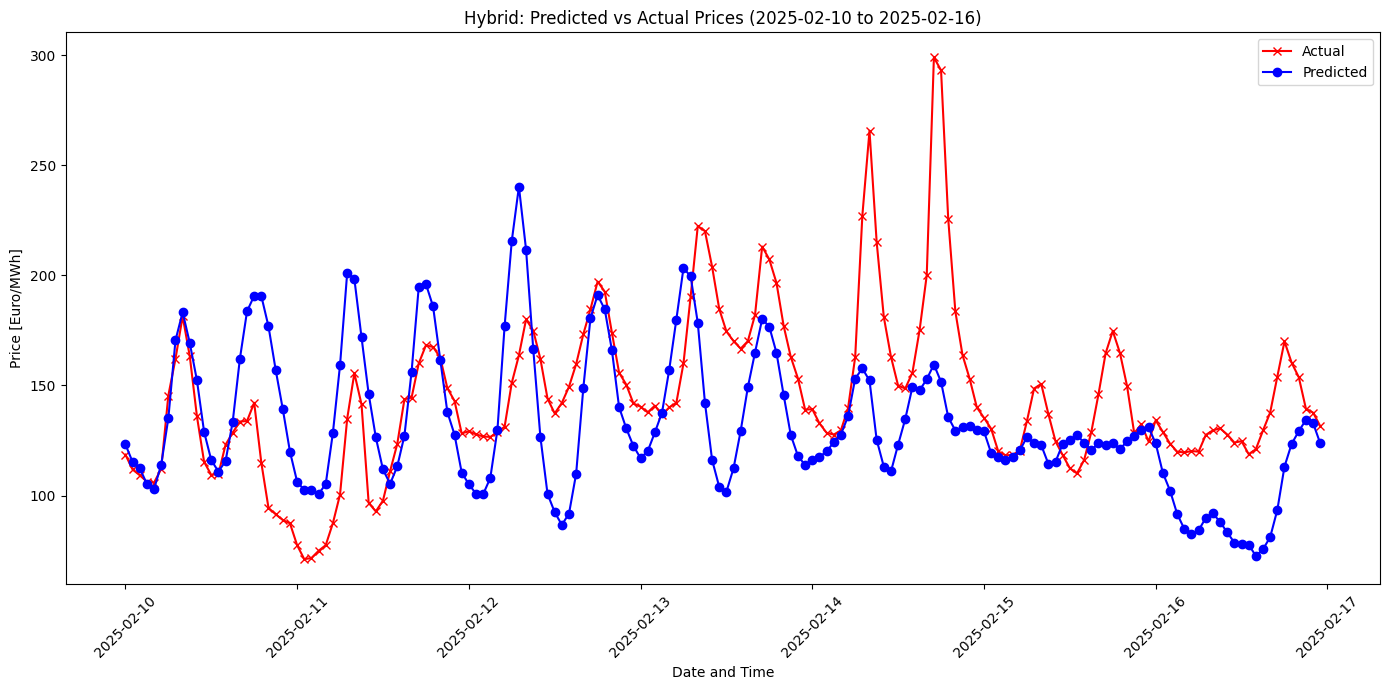

=== Hybrid (Future) Evaluation ===
RMSE: 39.54
MAE: 30.00
R²: -0.1828
MAPE: 20.66%
SMAPE: 21.57%

Model Performance Comparison:
XGBoost: RMSE=35.61, MAE=27.40, R²=0.041, MAPE=18.19%, SMAPE=19.76%
LSTM: RMSE=51.26, MAE=40.88, R²=-0.987, MAPE=27.37%, SMAPE=29.70%
Hybrid: RMSE=39.54, MAE=30.00, R²=-0.183, MAPE=20.66%, SMAPE=21.57%


In [24]:
# Step 9: Future Forecasting
actual_data = [
    {"start date/time": "2025-02-10 00:00:00", "actual_price": 118.58},
    {"start date/time": "2025-02-10 01:00:00", "actual_price": 111.82},
    {"start date/time": "2025-02-10 02:00:00", "actual_price": 109.22},
    {"start date/time": "2025-02-10 03:00:00", "actual_price": 106.29},
    {"start date/time": "2025-02-10 04:00:00", "actual_price": 105.85},
    {"start date/time": "2025-02-10 05:00:00", "actual_price": 112.00},
    {"start date/time": "2025-02-10 06:00:00", "actual_price": 145.38},
    {"start date/time": "2025-02-10 07:00:00", "actual_price": 162.02},
    {"start date/time": "2025-02-10 08:00:00", "actual_price": 181.36},
    {"start date/time": "2025-02-10 09:00:00", "actual_price": 163.18},
    {"start date/time": "2025-02-10 10:00:00", "actual_price": 135.90},
    {"start date/time": "2025-02-10 11:00:00", "actual_price": 115.28},
    {"start date/time": "2025-02-10 12:00:00", "actual_price": 109.36},
    {"start date/time": "2025-02-10 13:00:00", "actual_price": 109.74},
    {"start date/time": "2025-02-10 14:00:00", "actual_price": 123.07},
    {"start date/time": "2025-02-10 15:00:00", "actual_price": 128.54},
    {"start date/time": "2025-02-10 16:00:00", "actual_price": 133.58},
    {"start date/time": "2025-02-10 17:00:00", "actual_price": 133.82},
    {"start date/time": "2025-02-10 18:00:00", "actual_price": 142.11},
    {"start date/time": "2025-02-10 19:00:00", "actual_price": 114.85},
    {"start date/time": "2025-02-10 20:00:00", "actual_price": 94.37},
    {"start date/time": "2025-02-10 21:00:00", "actual_price": 91.48},
    {"start date/time": "2025-02-10 22:00:00", "actual_price": 88.87},
    {"start date/time": "2025-02-10 23:00:00", "actual_price": 87.38},
    {"start date/time": "2025-02-11 00:00:00", "actual_price": 77.45},
    {"start date/time": "2025-02-11 01:00:00", "actual_price": 71.10},
    {"start date/time": "2025-02-11 02:00:00", "actual_price": 71.62},
    {"start date/time": "2025-02-11 03:00:00", "actual_price": 74.89},
    {"start date/time": "2025-02-11 04:00:00", "actual_price": 77.45},
    {"start date/time": "2025-02-11 05:00:00", "actual_price": 87.44},
    {"start date/time": "2025-02-11 06:00:00", "actual_price": 100.46},
    {"start date/time": "2025-02-11 07:00:00", "actual_price": 134.93},
    {"start date/time": "2025-02-11 08:00:00", "actual_price": 155.53},
    {"start date/time": "2025-02-11 09:00:00", "actual_price": 141.42},
    {"start date/time": "2025-02-11 10:00:00", "actual_price": 96.65},
    {"start date/time": "2025-02-11 11:00:00", "actual_price": 92.78},
    {"start date/time": "2025-02-11 12:00:00", "actual_price": 97.68},
    {"start date/time": "2025-02-11 13:00:00", "actual_price": 111.11},
    {"start date/time": "2025-02-11 14:00:00", "actual_price": 123.46},
    {"start date/time": "2025-02-11 15:00:00", "actual_price": 143.69},
    {"start date/time": "2025-02-11 16:00:00", "actual_price": 144.47},
    {"start date/time": "2025-02-11 17:00:00", "actual_price": 159.97},
    {"start date/time": "2025-02-11 18:00:00", "actual_price": 168.19},
    {"start date/time": "2025-02-11 19:00:00", "actual_price": 167.45},
    {"start date/time": "2025-02-11 20:00:00", "actual_price": 162.63},
    {"start date/time": "2025-02-11 21:00:00", "actual_price": 148.75},
    {"start date/time": "2025-02-11 22:00:00", "actual_price": 142.95},
    {"start date/time": "2025-02-11 23:00:00", "actual_price": 128.24},
    {"start date/time": "2025-02-12 00:00:00", "actual_price": 129.13},
    {"start date/time": "2025-02-12 01:00:00", "actual_price": 127.77},
    {"start date/time": "2025-02-12 02:00:00", "actual_price": 126.82},
    {"start date/time": "2025-02-12 03:00:00", "actual_price": 126.59},
    {"start date/time": "2025-02-12 04:00:00", "actual_price": 128.74},
    {"start date/time": "2025-02-12 05:00:00", "actual_price": 131.24},
    {"start date/time": "2025-02-12 06:00:00", "actual_price": 151.13},
    {"start date/time": "2025-02-12 07:00:00", "actual_price": 163.64},
    {"start date/time": "2025-02-12 08:00:00", "actual_price": 180.00},
    {"start date/time": "2025-02-12 09:00:00", "actual_price": 174.92},
    {"start date/time": "2025-02-12 10:00:00", "actual_price": 162.05},
    {"start date/time": "2025-02-12 11:00:00", "actual_price": 144.01},
    {"start date/time": "2025-02-12 12:00:00", "actual_price": 137.28},
    {"start date/time": "2025-02-12 13:00:00", "actual_price": 142.03},
    {"start date/time": "2025-02-12 14:00:00", "actual_price": 149.40},
    {"start date/time": "2025-02-12 15:00:00", "actual_price": 159.67},
    {"start date/time": "2025-02-12 16:00:00", "actual_price": 173.21},
    {"start date/time": "2025-02-12 17:00:00", "actual_price": 184.59},
    {"start date/time": "2025-02-12 18:00:00", "actual_price": 197.13},
    {"start date/time": "2025-02-12 19:00:00", "actual_price": 192.57},
    {"start date/time": "2025-02-12 20:00:00", "actual_price": 173.90},
    {"start date/time": "2025-02-12 21:00:00", "actual_price": 155.78},
    {"start date/time": "2025-02-12 22:00:00", "actual_price": 150.38},
    {"start date/time": "2025-02-12 23:00:00", "actual_price": 141.81},
    {"start date/time": "2025-02-13 00:00:00", "actual_price": 140.33},
    {"start date/time": "2025-02-13 01:00:00", "actual_price": 137.75},
    {"start date/time": "2025-02-13 02:00:00", "actual_price": 140.79},
    {"start date/time": "2025-02-13 03:00:00", "actual_price": 136.59},
    {"start date/time": "2025-02-13 04:00:00", "actual_price": 140.00},
    {"start date/time": "2025-02-13 05:00:00", "actual_price": 142.00},
    {"start date/time": "2025-02-13 06:00:00", "actual_price": 159.99},
    {"start date/time": "2025-02-13 07:00:00", "actual_price": 190.33},
    {"start date/time": "2025-02-13 08:00:00", "actual_price": 222.36},
    {"start date/time": "2025-02-13 09:00:00", "actual_price": 220.05},
    {"start date/time": "2025-02-13 10:00:00", "actual_price": 203.89},
    {"start date/time": "2025-02-13 11:00:00", "actual_price": 184.68},
    {"start date/time": "2025-02-13 12:00:00", "actual_price": 174.52},
    {"start date/time": "2025-02-13 13:00:00", "actual_price": 170.10},
    {"start date/time": "2025-02-13 14:00:00", "actual_price": 166.70},
    {"start date/time": "2025-02-13 15:00:00", "actual_price": 170.10},
    {"start date/time": "2025-02-13 16:00:00", "actual_price": 182.00},
    {"start date/time": "2025-02-13 17:00:00", "actual_price": 213.05},
    {"start date/time": "2025-02-13 18:00:00", "actual_price": 207.17},
    {"start date/time": "2025-02-13 19:00:00", "actual_price": 196.52},
    {"start date/time": "2025-02-13 20:00:00", "actual_price": 177.03},
    {"start date/time": "2025-02-13 21:00:00", "actual_price": 162.92},
    {"start date/time": "2025-02-13 22:00:00", "actual_price": 153.12},
    {"start date/time": "2025-02-13 23:00:00", "actual_price": 138.97},
    {"start date/time": "2025-02-14 00:00:00", "actual_price": 139.21},
    {"start date/time": "2025-02-14 01:00:00", "actual_price": 132.80},
    {"start date/time": "2025-02-14 02:00:00", "actual_price": 128.50},
    {"start date/time": "2025-02-14 03:00:00", "actual_price": 127.65},
    {"start date/time": "2025-02-14 04:00:00", "actual_price": 129.58},
    {"start date/time": "2025-02-14 05:00:00", "actual_price": 139.59},
    {"start date/time": "2025-02-14 06:00:00", "actual_price": 162.89},
    {"start date/time": "2025-02-14 07:00:00", "actual_price": 227.08},
    {"start date/time": "2025-02-14 08:00:00", "actual_price": 265.64},
    {"start date/time": "2025-02-14 09:00:00", "actual_price": 215.11},
    {"start date/time": "2025-02-14 10:00:00", "actual_price": 181.03},
    {"start date/time": "2025-02-14 11:00:00", "actual_price": 163.01},
    {"start date/time": "2025-02-14 12:00:00", "actual_price": 149.86},
    {"start date/time": "2025-02-14 13:00:00", "actual_price": 148.61},
    {"start date/time": "2025-02-14 14:00:00", "actual_price": 155.80},
    {"start date/time": "2025-02-14 15:00:00", "actual_price": 175.06},
    {"start date/time": "2025-02-14 16:00:00", "actual_price": 200.00},
    {"start date/time": "2025-02-14 17:00:00", "actual_price": 298.91},
    {"start date/time": "2025-02-14 18:00:00", "actual_price": 293.06},
    {"start date/time": "2025-02-14 19:00:00", "actual_price": 225.70},
    {"start date/time": "2025-02-14 20:00:00", "actual_price": 183.55},
    {"start date/time": "2025-02-14 21:00:00", "actual_price": 163.79},
    {"start date/time": "2025-02-14 22:00:00", "actual_price": 153.00},
    {"start date/time": "2025-02-14 23:00:00", "actual_price": 140.03},
    {"start date/time": "2025-02-15 00:00:00", "actual_price": 135.29},
    {"start date/time": "2025-02-15 01:00:00", "actual_price": 130.34},
    {"start date/time": "2025-02-15 02:00:00", "actual_price": 120.00},
    {"start date/time": "2025-02-15 03:00:00", "actual_price": 118.24},
    {"start date/time": "2025-02-15 04:00:00", "actual_price": 118.45},
    {"start date/time": "2025-02-15 05:00:00", "actual_price": 120.37},
    {"start date/time": "2025-02-15 06:00:00", "actual_price": 133.74},
    {"start date/time": "2025-02-15 07:00:00", "actual_price": 148.58},
    {"start date/time": "2025-02-15 08:00:00", "actual_price": 150.67},
    {"start date/time": "2025-02-15 09:00:00", "actual_price": 137.01},
    {"start date/time": "2025-02-15 10:00:00", "actual_price": 124.59},
    {"start date/time": "2025-02-15 11:00:00", "actual_price": 118.36},
    {"start date/time": "2025-02-15 12:00:00", "actual_price": 112.39},
    {"start date/time": "2025-02-15 13:00:00", "actual_price": 110.01},
    {"start date/time": "2025-02-15 14:00:00", "actual_price": 116.15},
    {"start date/time": "2025-02-15 15:00:00", "actual_price": 128.83},
    {"start date/time": "2025-02-15 16:00:00", "actual_price": 145.89},
    {"start date/time": "2025-02-15 17:00:00", "actual_price": 164.54},
    {"start date/time": "2025-02-15 18:00:00", "actual_price": 174.70},
    {"start date/time": "2025-02-15 19:00:00", "actual_price": 164.76},
    {"start date/time": "2025-02-15 20:00:00", "actual_price": 149.65},
    {"start date/time": "2025-02-15 21:00:00", "actual_price": 128.31},
    {"start date/time": "2025-02-15 22:00:00", "actual_price": 132.37},
    {"start date/time": "2025-02-15 23:00:00", "actual_price": 124.54},
    {"start date/time": "2025-02-16 00:00:00", "actual_price": 134.11},
    {"start date/time": "2025-02-16 01:00:00", "actual_price": 128.90},
    {"start date/time": "2025-02-16 02:00:00", "actual_price": 123.57},
    {"start date/time": "2025-02-16 03:00:00", "actual_price": 119.90},
    {"start date/time": "2025-02-16 04:00:00", "actual_price": 119.57},
    {"start date/time": "2025-02-16 05:00:00", "actual_price": 120.18},
    {"start date/time": "2025-02-16 06:00:00", "actual_price": 119.92},
    {"start date/time": "2025-02-16 07:00:00", "actual_price": 127.51},
    {"start date/time": "2025-02-16 08:00:00", "actual_price": 129.60},
    {"start date/time": "2025-02-16 09:00:00", "actual_price": 130.49},
    {"start date/time": "2025-02-16 10:00:00", "actual_price": 127.70},
    {"start date/time": "2025-02-16 11:00:00", "actual_price": 124.03},
    {"start date/time": "2025-02-16 12:00:00", "actual_price": 124.67},
    {"start date/time": "2025-02-16 13:00:00", "actual_price": 118.77},
    {"start date/time": "2025-02-16 14:00:00", "actual_price": 121.02},
    {"start date/time": "2025-02-16 15:00:00", "actual_price": 129.55},
    {"start date/time": "2025-02-16 16:00:00", "actual_price": 137.68},
    {"start date/time": "2025-02-16 17:00:00", "actual_price": 153.98},
    {"start date/time": "2025-02-16 18:00:00", "actual_price": 169.98},
    {"start date/time": "2025-02-16 19:00:00", "actual_price": 160.29},
    {"start date/time": "2025-02-16 20:00:00", "actual_price": 153.72},
    {"start date/time": "2025-02-16 21:00:00", "actual_price": 139.34},
    {"start date/time": "2025-02-16 22:00:00", "actual_price": 137.62},
    {"start date/time": "2025-02-16 23:00:00", "actual_price": 131.51}
]

actual_df = pd.DataFrame(actual_data)
actual_df['StartDateTime'] = pd.to_datetime(actual_df['start date/time'])

# XGBoost Forecasting
last_hist_xgb = historical_data.tail(48)
price_history_xgb = list(last_hist_xgb['Price'])
predictions_xgb = []

for idx, row in future_data.iterrows():
    feature_vector = []
    for feature in common_features:
        if feature in ['Lag_Price_1h', 'Lag_Price_24h']:
            lag = int(feature.split('_')[-1].replace('h', ''))
            value = predictions_xgb[-lag] if len(predictions_xgb) >= lag else price_history_xgb[-lag]
            feature_vector.append(value)
        elif 'Rolling' in feature or 'Std' in feature:
            feature_vector.append(row[feature] if pd.notna(row[feature]) else last_hist_xgb[feature].mean())
        else:
            feature_vector.append(row[feature])
    feature_vector_scaled = scaler_xgb.transform([feature_vector])
    pred_price = model_xgb.predict(feature_vector_scaled)[0]
    predictions_xgb.append(pred_price)
    price_history_xgb.append(pred_price)

future_data['Predicted Price [Euro/MWh] XGBoost'] = predictions_xgb

# LSTM Forecasting
last_hist_lstm = historical_data.tail(time_steps)
last_hist_lstm[common_features] = last_hist_lstm[common_features].ffill().bfill()
initial_sequence = scaler_X_lstm.transform(last_hist_lstm[common_features].values)
price_history_lstm = list(historical_data['Price'])
predictions_lstm = []

for idx, row in future_data.iterrows():
    features_for_pred = []
    for feature in common_features:
        if 'Lag_Price' in feature:
            lag = int(feature.split('_')[-1].replace('h', ''))
            value = (predictions_lstm[-lag] if len(predictions_lstm) >= lag and not np.isnan(predictions_lstm[-lag])
                     else price_history_lstm[-lag])
            features_for_pred.append(value)
        elif 'Rolling' in feature or 'Std' in feature:
            features_for_pred.append(row[feature] if pd.notna(row[feature]) else last_hist_lstm[feature].mean())
        else:
            features_for_pred.append(row[feature] if pd.notna(row[feature]) else historical_data[feature].mean())

    features_for_pred = pd.Series(features_for_pred, index=common_features).fillna(historical_data[common_features].mean()).values
    features_scaled = scaler_X_lstm.transform([features_for_pred])
    initial_sequence = np.roll(initial_sequence, -1, axis=0)
    initial_sequence[-1] = features_scaled[0]
    input_seq = initial_sequence.reshape(1, time_steps, len(common_features))
    pred_scaled = model_lstm.predict(input_seq, verbose=0).flatten()[0]

    if np.isnan(pred_scaled):
        pred_scaled = scaler_y_lstm.transform([[price_history_lstm[-1]]])[0][0]

    pred_price = scaler_y_lstm.inverse_transform([[pred_scaled]])[0][0]
    predictions_lstm.append(pred_price)
    price_history_lstm.append(pred_price)

future_data['Predicted Price [Euro/MWh] LSTM'] = predictions_lstm

# Hybrid Forecasting (LSTM + XGBoost)
last_hist_hybrid = historical_data.tail(24)
price_history_hybrid = list(last_hist_hybrid['Price'])
predictions_hybrid = []
hybrid_features = common_features + ['LSTM_pred']

for idx, row in future_data.iterrows():
    new_row = pd.Series(index=hybrid_features, dtype=float)
    for feature in common_features:
        if feature in ['total_consumption', 'temperature', 'wind_speed', 'relative_humidity', 'Hour_sin', 'Hour_cos']:
            new_row[feature] = row[feature]
        elif feature == 'Lag_Price_1h':
            new_row[feature] = predictions_hybrid[-1] if predictions_hybrid else price_history_hybrid[-1]
        elif feature == 'Lag_Price_24h':
            new_row[feature] = predictions_hybrid[-24] if len(predictions_hybrid) >= 24 else price_history_hybrid[-24]
        elif 'Rolling' in feature or 'Std' in feature:
            prices = price_history_hybrid + predictions_hybrid
            if feature == 'Price_RollingStd24':
                new_row[feature] = np.std(prices[-24:]) if len(prices) >= 24 else 0
            else:
                new_row[feature] = row[feature] if pd.notna(row[feature]) else last_hist_hybrid[feature].mean()
    new_row['LSTM_pred'] = predictions_lstm[idx]
    new_row = new_row.fillna(0)
    new_row_scaled = scaler_hybrid.transform(new_row.to_frame().T)
    pred_price_log = model_hybrid.predict(new_row_scaled)[0]
    pred_price = np.expm1(pred_price_log)
    predictions_hybrid.append(pred_price)
    price_history_hybrid.append(pred_price)

future_data['Predicted Price [Euro/MWh] Hybrid'] = predictions_hybrid

# ### Model Evaluation on Out-of-Sample Data
evaluation_results = {}
for model_name, pred_col in [('XGBoost', 'Predicted Price [Euro/MWh] XGBoost'),
                             ('LSTM', 'Predicted Price [Euro/MWh] LSTM'),
                             ('Hybrid', 'Predicted Price [Euro/MWh] Hybrid')]:
    merged_df = pd.merge(
        future_data[['StartDateTime', pred_col]],
        actual_df[['StartDateTime', 'actual_price']],
        on='StartDateTime',
        how='inner'
    )
    if not merged_df.empty:
        print(f"\nEvaluating {model_name} on period: {merged_df['StartDateTime'].min()} to {merged_df['StartDateTime'].max()}")
        plot_predictions(
            merged_df['StartDateTime'],
            merged_df['actual_price'],
            merged_df[pred_col],
            f"{model_name}: Predicted vs Actual Prices (2025-02-10 to 2025-02-16)"
        )
        metrics = evaluate_model(merged_df['actual_price'], merged_df[pred_col], f"{model_name} (Future)", return_metrics=True)
        evaluation_results[model_name] = metrics
    else:
        print(f"No overlapping data found for {model_name} evaluation.")

# Compare model performance
if evaluation_results:
    print("\nModel Performance Comparison:")
    for model_name, (rmse, mae, r2, mape, smape) in evaluation_results.items():
        print(f"{model_name}: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.3f}, MAPE={mape:.2f}%, SMAPE={smape:.2f}%")

####End